## Can film be clustered by their emotional tone? And do these cluster reveal distinct patterns in consumer ratings?

In [3]:
import pandas as pd
import numpy as np 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from utils.methods import *

df = pd.read_csv('../../data/final_data_complete.csv')

temp = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))

emotions_df = pd.concat([df, temp], axis=1)
assert emotions_df["distilbert_emotions"].isna().sum() == emotions_df["Plot"].isna().sum()

In [4]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']

filter_df = emotions_df.dropna(subset=['Plot'])

cluster_df = filter_df[emotions].reset_index(drop=True)
cluster_df.head()
cluster_df.to_csv('../../data/cluster.csv', index=False)

#### The data are already on the same scale and sum to 1 representing proportions of the emotional tone of the film so there is no need to normalize them. 

#### We start from doing some exploration of the data.

(33684, 7)
(235788, 2)


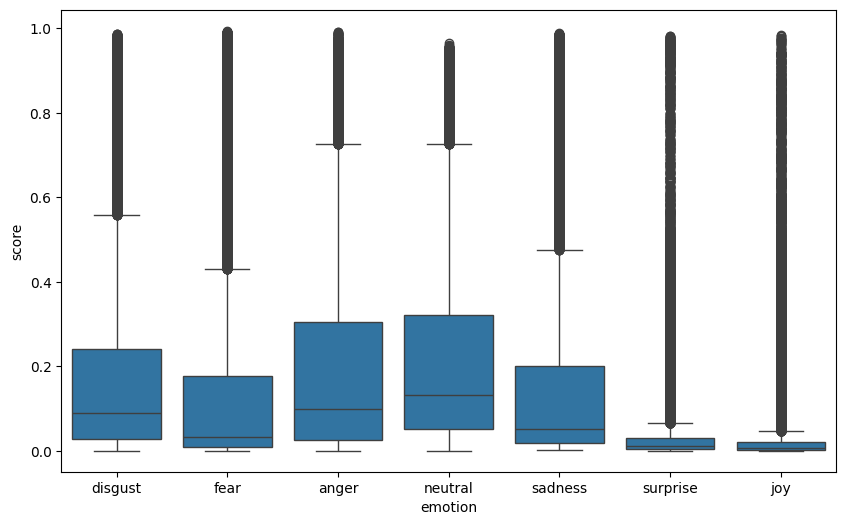

In [5]:
print(cluster_df.shape)

long_df = pd.melt(cluster_df, var_name='emotion', value_name='score')
print(long_df.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='score', data=long_df)
plt.show()

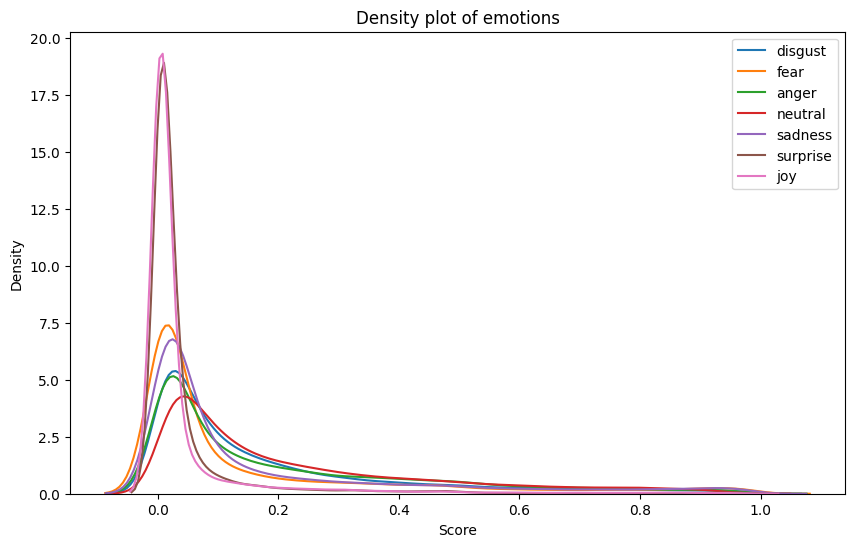

In [6]:
plt.figure(figsize=(10, 6))
for emotion in cluster_df.columns:
    sns.kdeplot(cluster_df[emotion], label=emotion, fill=False)
plt.xlabel('Score')
plt.legend()
plt.title('Density plot of emotions')
plt.show()


#### To start, we perform a Hierchical Clustering o the data and plot the dendrogram to see if there are any clear clusters.

#### We will perform Hierchical Clustering with average linkage and Cosine distance. The Cosine distance is chosen because it is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Thats works particularly well when the data are in distributed in a simplex like in this case.

#### Since Hierchical Clustiering computes dinstances between all pairs of points, it scales poorly with large dataset like ours. To have and understandig of the possible clusters we will use a subset of 500 data points.

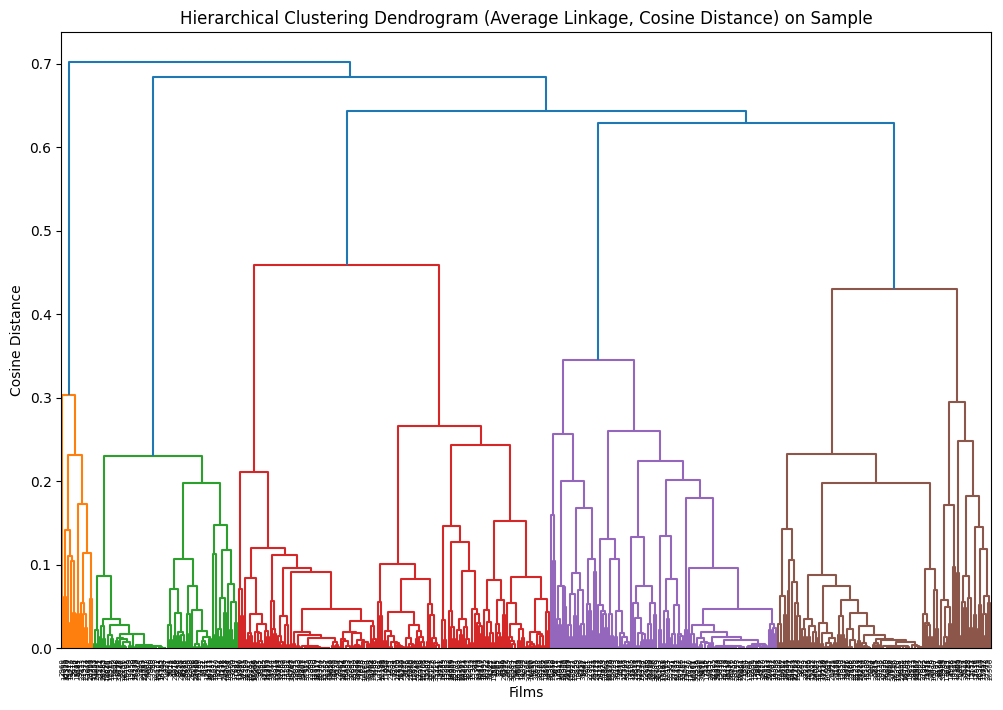

In [12]:
#Perform Hierarchical Clustering with average linkage and cosine distance, no normalization
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

sample_df = cluster_df.sample(500, random_state=42)

distance_matrix = pdist(sample_df, metric='cosine')
linkage_matrix = linkage(distance_matrix, method='average')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=sample_df.index, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (Average Linkage, Cosine Distance) on Sample')
plt.xlabel('Films')
plt.ylabel('Cosine Distance')
plt.show()


In [14]:
cutoff = 0.3

cluster_labels = fcluster(linkage_matrix, t = cutoff, criterion='distance')
sample_df['cluster'] = cluster_labels

cluster_summary = sample_df.groupby('cluster').mean() 

distance_square = squareform(distance_matrix)

def compute_inner_cluster_distances(labels, distances):
    unique_clusters = np.unique(labels)
    inner_distances = {}
    for cluster in unique_clusters:
        indices = np.where(labels == cluster)[0]
        if len(indices) > 1:
            intra_dist = distances[np.ix_(indices, indices)].mean()
        else:
            intra_dist = 0  # Single-point cluster
        inner_distances[cluster] = intra_dist
    return inner_distances

inner_cluster_distances = compute_inner_cluster_distances(cluster_labels, distance_square)
inner_cluster_distances



{1: 0.1643354618706197,
 2: 0,
 3: 0.1548717409338018,
 4: 0.08524913979233686,
 5: 0.19856307786260435,
 6: 0.16668038289211468,
 7: 0.16940779147937568,
 8: 0.12105150467831619,
 9: 0.20818028729421426}

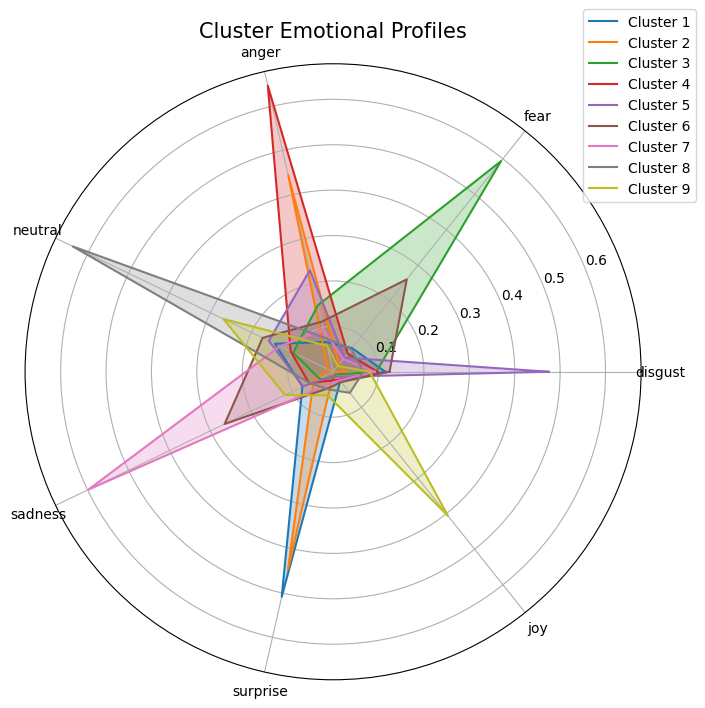

In [15]:
def plot_radar_chart(data, title):
    categories = data.columns
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
        
    ax.set_title(title, size=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

plot_radar_chart(cluster_summary, "Cluster Emotional Profiles")

